In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from joblib import dump, load

from data_engineering import read_data, get_filter_duplicates_query

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from keras import layers, models, optimizers, callbacks, regularizers

### Чтение данных

In [6]:
DATA_PATH = '/home/ataleckij/Projects/university/MO_4sem/laba1-3/data/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'notMNIST_large/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'notMNIST_small/')

In [7]:
work_features_matrix, work_labels = read_data(TRAIN_DATA_PATH)
test_features_matrix, test_labels = read_data(TEST_DATA_PATH)

print(work_features_matrix.shape, test_features_matrix.shape)
print(work_labels.shape, test_labels.shape)

D: 100%|██████████| 52912/52912 [00:10<00:00, 5149.16it/s]


error: total=5, percent=9.449759409125443e-06


D: 100%|██████████| 1873/1873 [00:00<00:00, 5243.36it/s]

error: total=2, percent=0.00010681478316599017
(529114, 28, 28) (18724, 28, 28)
(529114,) (18724,)


In [8]:
print(pd.Series(work_labels).value_counts())
print(pd.Series(test_labels).value_counts())

F    52912
E    52912
G    52912
C    52912
H    52912
I    52912
J    52911
D    52911
B    52911
A    52909
dtype: int64
E    1873
D    1873
B    1873
C    1873
H    1872
G    1872
I    1872
J    1872
A    1872
F    1872
dtype: int64


TRAIN IMAGES SAMPLES
D


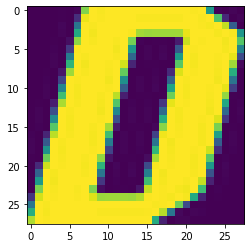

I


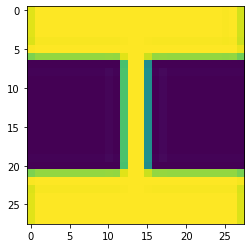

E


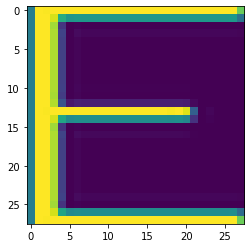

J


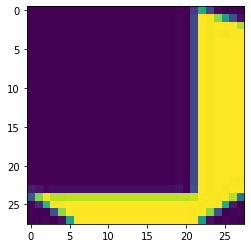

TEST IMAGES SAMPLES
B


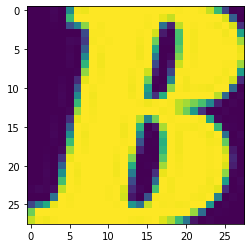

C


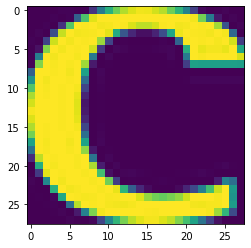

F


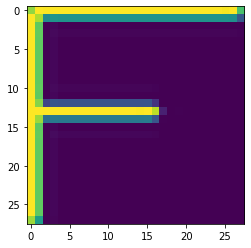

H


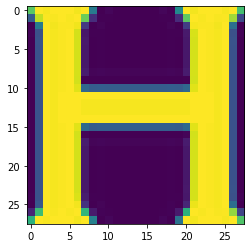

In [9]:
def plt_few_random_images(features_matrix, labels, count=4):
    for _ in range(count):
        i = np.random.randint(features_matrix.shape[0])
        print(labels[i])
        plt.imshow(features_matrix[i])
        plt.show()

print('TRAIN IMAGES SAMPLES')
plt_few_random_images(work_features_matrix, work_labels)
print('TEST IMAGES SAMPLES')
plt_few_random_images(test_features_matrix, test_labels)

### Удаление дубликатов данных

#### Фильтрация хешами

In [10]:
filter_query = get_filter_duplicates_query(work_features_matrix)
filter_query.shape

100%|██████████| 529114/529114 [00:05<00:00, 102124.09it/s]


(461946,)

In [11]:
work_features_matrix = work_features_matrix[filter_query]
work_labels = work_labels[filter_query]

In [12]:
filter_query = get_filter_duplicates_query(work_features_matrix, test_features_matrix)
filter_query.shape

100%|██████████| 461946/461946 [00:04<00:00, 105233.35it/s]


(457363,)

In [13]:
work_features_matrix = work_features_matrix[filter_query]
work_labels = work_labels[filter_query]

#### Фильтрация расстояниями

### Разделение данных

In [14]:
train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
                                              test_size=0.07, stratify=work_labels, random_state=42)
# train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
#                                               test_size=0.50, stratify=work_labels, random_state=42)

print(train_indixes.shape, val_indexes.shape)

(425347,) (32016,)


In [15]:
train_features_matrix, train_labels = work_features_matrix[train_indixes], work_labels[train_indixes]
val_features_matrix, val_labels = work_features_matrix[val_indexes], work_labels[val_indexes]

### Обучение простого классификатора (результат 0.9626)

In [13]:
def flatten(features_matrix):
    flatten_shape = (features_matrix.shape[0], np.prod(features_matrix.shape[1:]))
    return features_matrix.reshape(flatten_shape)

In [14]:
# work_features = flatten(work_features_matrix)
train_features = flatten(train_features_matrix)
val_features = flatten(val_features_matrix)
test_features = flatten(test_features_matrix)

In [17]:
# clf = load('svm_0.9626')
# pca = load('pca_0.9626')

# train_features = pca.transform(train_features/255)
# val_features = pca.transform(val_features/255)
# test_features = pca.transform(test_features/255)

# clf

pca = PCA(n_components=50)

train_features = pca.fit_transform(train_features/255)
val_features = pca.transform(val_features/255)
test_features = pca.transform(test_features/255)

clf = SVC(C=15, random_state=42, kernel='rbf')  # , max_iter=100
clf

SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [125]:
clf.fit(train_features, train_labels)

SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [18]:
clf.score(train_features, train_labels)

0.9662324373253571

In [19]:
clf.score(val_features, val_labels)

0.9072992190028074

#### контрольное тест

In [127]:
clf.score(test_features, test_labels)

0.9626148258919034

если увеличить n_components или train_size можно ещё увеличить качество

In [129]:
dump(clf, 'svm_0.9626')
dump(pca, 'pca_0.9626')

# clf = load('svm_0.9626')
# pca = load('pca_0.9626')

['pca_0.9626']

Кривые обучения 50, 100, 1000, 50000

In [112]:
def get_learning_curves():
    train_values_counts, train_scores, val_scores = [], [], []
    for test_size in tqdm([0.99989, 0.99978, 0.9978, 0.8906]):  # 50, 100, 1000, 50000
        train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
                                                  test_size=test_size, stratify=work_labels, random_state=42)
        train_features_matrix, train_labels = work_features_matrix[train_indixes], work_labels[train_indixes]
        val_features_matrix, val_labels = work_features_matrix[val_indexes], work_labels[val_indexes]
        train_features = flatten(train_features_matrix)
        val_features = flatten(val_features_matrix)
        train_features = pca.fit_transform(train_features/255)
        val_features = pca.transform(val_features/255)
        clf.fit(train_features, train_labels)
        train_values_counts.append(train_features.shape[0])
        train_scores.append(clf.score(train_features, train_labels))
        val_scores.append(clf.score(val_features[:50000], val_labels[:50000]))
    return train_values_counts, train_scores, val_scores

train_values_counts, train_scores, val_scores = get_learning_curves()

100%|██████████| 4/4 [03:26<00:00, 51.71s/it]


[50, 100, 1006, 50035]


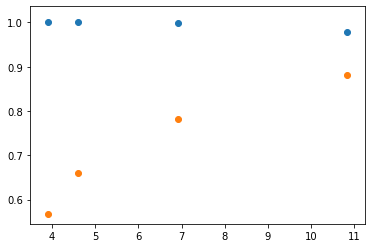

In [116]:
print(train_values_counts)
plt.scatter(np.log(train_values_counts), train_scores)
plt.scatter(np.log(train_values_counts), val_scores)
plt.show()

### Нейронные сети

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
val_labels_encoded = le.transform(val_labels)
work_labels_encoded = le.transform(work_labels)
test_labels_encoded = le.transform(test_labels)

#### Полносвязанная сеть (результат 0.9682)

In [16]:
def get_fc_model(size):
    x = input_ = layers.Input((size, size))
    x = flatten_input = layers.Flatten()(x)
    
    x1 = layers.Dense(512, activation='selu')(x)
    x1 = layers.Dropout(0.5)(x1)
    x2 = layers.Dense(256, activation='selu')(x)
    x = layers.concatenate([x1, x2])
    
    x1 = layers.Dense(256, activation='selu')(x)
    x1 = layers.Dropout(0.5)(x1)
    x2 = layers.Dense(128, activation='selu')(x)
    x = layers.concatenate([x1, x2])
    
    x1 = layers.Dense(128, activation='selu')(x)
    x1 = layers.Dropout(0.4)(x1)
    x2 = layers.Dense(64, activation='selu')(x)
    x = layers.concatenate([x1, x2])
    
    x = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(input_, x)

In [17]:
fc_model = get_fc_model(28)
print(fc_model.summary())

fc_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      flatten_1[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           dense_1[0][0]                   

In [18]:
fc_model.fit(train_features_matrix/255, train_labels_encoded,
             batch_size=256, epochs=150,
             validation_data=(val_features_matrix/255, val_labels_encoded),
             callbacks=[lr_reducer, stopper])


Train on 425347 samples, validate on 32016 samples
Epoch 1/150
425347/425347 [==============================] - 8s 19us/step - loss: 0.6235 - acc: 0.8201 - val_loss: 0.4434 - val_acc: 0.8617
Epoch 2/150
425347/425347 [==============================] - 7s 17us/step - loss: 0.4335 - acc: 0.8659 - val_loss: 0.3929 - val_acc: 0.8792
Epoch 3/150
425347/425347 [==============================] - 7s 16us/step - loss: 0.3904 - acc: 0.8783 - val_loss: 0.3716 - val_acc: 0.8837
Epoch 4/150
425347/425347 [==============================] - 6s 15us/step - loss: 0.3623 - acc: 0.8869 - val_loss: 0.3560 - val_acc: 0.8884
Epoch 5/150
425347/425347 [==============================] - 6s 15us/step - loss: 0.3420 - acc: 0.8925 - val_loss: 0.3474 - val_acc: 0.8939
Epoch 6/150
425347/425347 [==============================] - 6s 15us/step - loss: 0.3257 - acc: 0.8973 - val_loss: 0.3320 - val_acc: 0.8965
Epoch 7/150
425347/425347 [==============================] - 6s 15us/step - loss: 0.3128 - acc: 0.9010 - val

In [19]:
fc_model.evaluate(test_features_matrix/255, test_labels_encoded)

18724/18724 [==============================] - 1s 34us/step


[0.10926197761747547, 0.9668874144554138]

In [20]:
fc_model_full = get_fc_model(28)

fc_model_full.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

fc_model_full.fit(work_features_matrix/255, work_labels_encoded,
                  batch_size=256, epochs=150,
                  callbacks=[lr_reducer, stopper])

Epoch 1/150
457363/457363 [==============================] - 11s 25us/step - loss: 0.6153 - acc: 0.8217
Epoch 2/150
457363/457363 [==============================] - 11s 23us/step - loss: 0.4298 - acc: 0.8670
Epoch 3/150
457363/457363 [==============================] - 12s 27us/step - loss: 0.3864 - acc: 0.8798
Epoch 4/150
457363/457363 [==============================] - 9s 19us/step - loss: 0.3588 - acc: 0.8874
Epoch 5/150
457363/457363 [==============================] - 8s 17us/step - loss: 0.3392 - acc: 0.8932
Epoch 6/150
457363/457363 [==============================] - 7s 16us/step - loss: 0.3242 - acc: 0.8975
Epoch 7/150
457363/457363 [==============================] - 7s 16us/step - loss: 0.3106 - acc: 0.9012
Epoch 8/150
457363/457363 [==============================] - 8s 17us/step - loss: 0.2996 - acc: 0.9049
Epoch 9/150
457363/457363 [==============================] - 7s 16us/step - loss: 0.2894 - acc: 0.9076
Epoch 10/150
457363/457363 [==============================] - 7s 16us/

In [21]:
fc_model_full.evaluate(test_features_matrix/255, test_labels_encoded)

18724/18724 [==============================] - 1s 36us/step


[0.11043714238765694, 0.9682226181030273]

#### Сверточная сеть (результаты: 0.9706, 0.9604, 0.9733)

In [20]:
def get_conv_model1(size):
    x = input_ = layers.Input((size, size, 1))
#     x = layers.Reshape((size, size, 1))(x)
    
    x = layers.Conv2D(32, (5, 5), activation='relu')(x)
    x = layers.Conv2D(64, (5, 5), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(input_, x)

In [21]:
conv1_model = get_conv_model1(28)
print(conv1_model.summary())

conv1_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        51264     
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                256010    
Total params: 308,106
Trainable params: 308,106
Non-trainable params: 0
_____________________________________________________

In [22]:
conv1_model.fit(train_features_matrix[:, :, :, np.newaxis]/255, train_labels_encoded,
             batch_size=256, epochs=150,
             validation_data=(val_features_matrix[:, :, :, np.newaxis]/255, val_labels_encoded),
             callbacks=[lr_reducer, stopper])

Train on 425347 samples, validate on 32016 samples
Epoch 1/150
425347/425347 [==============================] - 23s 54us/step - loss: 0.4428 - accuracy: 0.8754 - val_loss: 0.3708 - val_accuracy: 0.8956
Epoch 2/150
425347/425347 [==============================] - 22s 52us/step - loss: 0.3478 - accuracy: 0.9015 - val_loss: 0.3306 - val_accuracy: 0.9061
Epoch 3/150
425347/425347 [==============================] - 22s 52us/step - loss: 0.3173 - accuracy: 0.9090 - val_loss: 0.3226 - val_accuracy: 0.9089
Epoch 4/150
425347/425347 [==============================] - 22s 52us/step - loss: 0.2966 - accuracy: 0.9146 - val_loss: 0.3215 - val_accuracy: 0.9099
Epoch 5/150
425347/425347 [==============================] - 22s 51us/step - loss: 0.2806 - accuracy: 0.9185 - val_loss: 0.3135 - val_accuracy: 0.9121

Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 6/150
425347/425347 [==============================] - 22s 51us/step - loss: 0.2382 - accuracy: 0.9304 - v

In [24]:
conv1_model.evaluate(test_features_matrix[:,:,:,np.newaxis]/255, test_labels_encoded)

18724/18724 [==============================] - 1s 50us/step


[0.10483772219814276, 0.9705725312232971]

In [30]:
def get_conv_model2(size):
    x = input_ = layers.Input((size, size, 1))
#     x = layers.Reshape((size, size, 1))(x)
    
    x = layers.Conv2D(128, (5, 5), activation='relu')(x)
    x = layers.MaxPool2D((3, 3))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(input_, x)

In [31]:
conv2_model = get_conv_model2(28)
print(conv2_model.summary())

conv2_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       3328      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                81930     
Total params: 85,258
Trainable params: 85,258
Non-trainable params: 0
_______________________________________________________

In [33]:
conv2_model.fit(train_features_matrix[:, :, :, np.newaxis]/255, train_labels_encoded,
             batch_size=256, epochs=150,
             validation_data=(val_features_matrix[:, :, :, np.newaxis]/255, val_labels_encoded),
             callbacks=[lr_reducer, stopper])

Train on 425347 samples, validate on 32016 samples
Epoch 1/150
425347/425347 [==============================] - 16s 38us/step - loss: 0.5185 - accuracy: 0.8587 - val_loss: 0.4385 - val_accuracy: 0.8808
Epoch 2/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.4370 - accuracy: 0.8808 - val_loss: 0.4068 - val_accuracy: 0.8891
Epoch 3/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.4176 - accuracy: 0.8850 - val_loss: 0.3945 - val_accuracy: 0.8924
Epoch 4/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.4044 - accuracy: 0.8890 - val_loss: 0.3865 - val_accuracy: 0.8934
Epoch 5/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.3951 - accuracy: 0.8913 - val_loss: 0.3784 - val_accuracy: 0.8962

Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 6/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.3761 - accuracy: 0.8961 - v

In [35]:
conv2_model.evaluate(test_features_matrix[:,:,:,np.newaxis]/255, test_labels_encoded)

18724/18724 [==============================] - 1s 36us/step


[0.1540607997454835, 0.9604251384735107]

In [74]:
def get_conv_model3(size):
    x = input_ = layers.Input((size, size, 1))
#     x = layers.Reshape((size, size, 1))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='tanh')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='tanh')(x)
    x = layers.Conv2D(64, (3, 3), activation='tanh')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
    x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='tanh')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(input_, x)

In [75]:
conv3_model = get_conv_model3(28)
print(conv3_model.summary())

conv3_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 3, 3, 128)         738

In [76]:
conv3_model.fit(train_features_matrix[:, :, :, np.newaxis]/255, train_labels_encoded,
             batch_size=256, epochs=150,
             validation_data=(val_features_matrix[:, :, :, np.newaxis]/255, val_labels_encoded),
             callbacks=[lr_reducer, stopper])

Train on 425347 samples, validate on 32016 samples
Epoch 1/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.4883 - accuracy: 0.8577 - val_loss: 0.3520 - val_accuracy: 0.8939
Epoch 2/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.3624 - accuracy: 0.8908 - val_loss: 0.3263 - val_accuracy: 0.9013
Epoch 3/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.3330 - accuracy: 0.8991 - val_loss: 0.3099 - val_accuracy: 0.9049
Epoch 4/150
425347/425347 [==============================] - 15s 36us/step - loss: 0.3169 - accuracy: 0.9032 - val_loss: 0.2960 - val_accuracy: 0.9089
Epoch 5/150
425347/425347 [==============================] - 16s 36us/step - loss: 0.3055 - accuracy: 0.9065 - val_loss: 0.2900 - val_accuracy: 0.9120
Epoch 6/150
425347/425347 [==============================] - 16s 37us/step - loss: 0.2970 - accuracy: 0.9092 - val_loss: 0.2985 - val_accuracy: 0.9066

Epoch 00006: ReduceLROnPlateau reducing le

In [77]:
conv3_model.evaluate(test_features_matrix[:,:,:,np.newaxis]/255, test_labels_encoded)

18724/18724 [==============================] - 1s 49us/step


[0.08941344746124477, 0.9733496904373169]